# Train custom object detector with TFLite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/TannerGilbert/TFLite-Object-Detection-with-TFLite-Model-Maker/blob/master/Train_custom_object_detector_with_TFLite_Model_Maker.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/TannerGilbert/TFLite-Object-Detection-with-TFLite-Model-Maker/blob/master/Train_custom_object_detector_with_TFLite_Model_Maker.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This notebook walks you through training a custom object detection model using the [TFLite Model Maker](https://www.tensorflow.org/lite/guide/model_maker). The TFLite Model Maker simplifies the process of training a TensorFlow Lite model using custom dataset.

The Model Maker library uses transfer learning to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

For this notebook my [Microcontroller Detection dataset](https://www.kaggle.com/tannergi/microcontroller-detection) is used. The dataset was labeled in Pascal VOC format using [LabelImg](https://github.com/tzutalin/labelImg).

![Microcontroller Detection](https://github.com/TannerGilbert/Tensorflow-Object-Detection-API-Train-Model/blob/master/doc/output.png?raw=1)

This notebook is based on the [Train_a_salad_detector_with_TFLite_Model_Maker.ipynb notebook](https://github.com/googlecodelabs/odml-pathways/blob/main/object-detection/codelab2/python/Train_a_salad_detector_with_TFLite_Model_Maker.ipynb) from [Google Codelabs](https://codelabs.developers.google.com/).


## Prerequisites


### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [ ]:
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

     |████████████████████████████████| 593kB 8.4MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 122kB 17.6MB/s 
     |████████████████████████████████| 686kB 18.7MB/s 
     |████████████████████████████████| 174kB 35.1MB/s 
     |████████████████████████████████| 92kB 13.1MB/s 
     |████████████████████████████████| 1.2MB 34.0MB/s 
     |████████████████████████████████| 645kB 50.4MB/s 
     |████████████████████████████████| 6.3MB 48.4MB/s 
     |████████████████████████████████| 112kB 57.0MB/s 
     |████████████████████████████████| 1.1MB 47.0MB/s 
     |████████████████████████████████| 849kB 42.3MB/s 
     |████████████████████████████████| 194kB 57.6MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 358kB 47.4MB/s 


Import the required packages.

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

### Prepare the dataset


In [ ]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 4.2MB 17.5MB/s 
     |████████████████████████████████| 143kB 56.2MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 112kB 58.5MB/s 
  ERROR: Failed building wheel for lxml
ERROR: tflite-model-maker 0.3.2 has requirement lxml>=4.6.1, but you'll have lxml 4.0.0 which is incompatible.
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-kfl67kff/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-kfl67kff/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-kk3yev0t/install-record.txt --single-version-externally-managed --compile Check the logs for full comm

In [ ]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "<username>" 
os.environ['KAGGLE_KEY'] = "<key>"

In [ ]:
!kaggle datasets download -d tannergi/microcontroller-detection --unzip

 60% 5.00M/8.34M [00:00<00:00, 36.1MB/s]
100% 8.34M/8.34M [00:00<00:00, 53.2MB/s]


In [ ]:
!mv "Microcontroller Detection" microcontroller-detection

## Train your object detection model

There are six steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite2 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture. 

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [ ]:
spec = model_spec.get('efficientdet_lite2')

**Step 2. Load the dataset.**

Model Maker can load data from multiple different formats, including [CSV format](https://cloud.google.com/vision/automl/object-detection/docs/csv-format) and [Pascal VOC](https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5). For more information, check out the [`tflite_model_maker.object_detector.DataLoader` documentation](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/DataLoader).

In [ ]:
train_data = object_detector.DataLoader.from_pascal_voc('microcontroller-detection/train', 'microcontroller-detection/train', ['Raspberry_Pi_3', 'Arduino_Nano', 'ESP8266', 'Heltec_ESP32_Lora'])

In [ ]:
validation_data = object_detector.DataLoader.from_pascal_voc('microcontroller-detection/test', 'microcontroller-detection/test', ['Raspberry_Pi_3', 'Arduino_Nano', 'ESP8266', 'Heltec_ESP32_Lora'])

**Step 3. Train the TensorFlow model with the training data.**

In [ ]:
model = object_detector.create(train_data, model_spec=spec, epochs=80, batch_size=8, train_whole_model=True, validation_data=validation_data)

Epoch 1/80
17/17 [==============================] - 74s 571ms/step - det_loss: 1.7288 - cls_loss: 1.1664 - box_loss: 0.0112 - reg_l2_loss: 0.0762 - loss: 1.8050 - learning_rate: 0.0090 - gradient_norm: 1.4915
Epoch 2/80
17/17 [==============================] - 8s 467ms/step - det_loss: 1.4412 - cls_loss: 1.0230 - box_loss: 0.0084 - reg_l2_loss: 0.0762 - loss: 1.5174 - learning_rate: 0.0100 - gradient_norm: 2.1140
Epoch 3/80
17/17 [==============================] - 8s 472ms/step - det_loss: 1.0999 - cls_loss: 0.7919 - box_loss: 0.0062 - reg_l2_loss: 0.0763 - loss: 1.1762 - learning_rate: 0.0100 - gradient_norm: 3.6826
Epoch 4/80
17/17 [==============================] - 8s 475ms/step - det_loss: 0.8682 - cls_loss: 0.6618 - box_loss: 0.0041 - reg_l2_loss: 0.0763 - loss: 0.9444 - learning_rate: 0.0100 - gradient_norm: 3.8280
Epoch 5/80
17/17 [==============================] - 8s 470ms/step - det_loss: 0.7365 - cls_loss: 0.5737 - box_loss: 0.0033 - reg_l2_loss: 0.0763 - loss: 0.8128 - learn

**Step 4. Evaluate the model with the test data.**

After training the object detection model using the images in the training dataset, use the remaining 25 images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 7 images in the test dataset.

In [ ]:
model.evaluate(validation_data)

1/1 [==============================] - 6s 6s/step



{'AP': 0.9129471,
 'AP50': 1.0,
 'AP75': 1.0,
 'AP_/Arduino_Nano': 0.80178857,
 'AP_/ESP8266': 1.0,
 'AP_/Heltec_ESP32_Lora': 0.85,
 'AP_/Raspberry_Pi_3': 1.0,
 'APl': 0.9130256,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.9375,
 'ARm': -1.0,
 'ARmax1': 0.9125,
 'ARmax10': 0.925,
 'ARmax100': 0.9375,
 'ARs': -1.0}

**Step 5.  Export as a TensorFlow Lite model.**

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is full integer quantization.

In [ ]:
model.export(export_dir='.')

**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop. 
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [ ]:
model.evaluate_tflite('model.tflite', validation_data)

7/7 [==============================] - 54s 8s/step



{'AP': 0.8691832,
 'AP50': 1.0,
 'AP75': 1.0,
 'AP_/Arduino_Nano': 0.8009901,
 'AP_/ESP8266': 0.92524755,
 'AP_/Heltec_ESP32_Lora': 0.85049504,
 'AP_/Raspberry_Pi_3': 0.9,
 'APl': 0.8691832,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.8875,
 'ARm': -1.0,
 'ARmax1': 0.8875,
 'ARmax10': 0.8875,
 'ARmax100': 0.8875,
 'ARs': -1.0}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click the `model.tflite` file and choose `Download` to download it to your local computer.

After training the model you can use the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview) to [integrate the object detector into an Android application](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector).

## (Optional) Compile for the Edge TPU

**Step 1. Install the EdgeTPU Compiler**

In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

!sudo apt-get update

!sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  66763      0 --:--:-- --:--:-- --:--:-- 66763
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 https://cloud.r-project.or

**Step 2. Select number of Edge TPUs, Compile**

The EdgeTPU has 8MB of SRAM for caching model paramaters ([more info](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching)). This means that for models that are larger than 8MB, inference time will be increased in order to transfer over model paramaters. One way to avoid this is [Model Pipelining](https://coral.ai/docs/edgetpu/pipeline/) - splitting the model into segments that can have a dedicated EdgeTPU. This can significantly improve latency.

The below table can be used as a reference for the number of Edge TPUs to use - the larger models will not compile for a single TPU as the intermediate tensors can't fit in on-chip memory.

| Model architecture  | Minimum TPUs | Recommended TPUs |
|        :---:        |    :---:     |      :---:       |
| EfficientDet-Lite0  | 1            | 1                |
| EfficientDet-Lite1  | 1            | 1                |
| EfficientDet-Lite2  | 1            | 2                |
| EfficientDet-Lite3  | 2            | 2                |
| EfficientDet-Lite4  | 2            | 3                |

In [ ]:
NUMBER_OF_TPUS =  1

!edgetpu_compiler model.tflite --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 8885 ms.

Input model: model.tflite
Input size: 7.04MiB
Output model: model_edgetpu.tflite
Output size: 9.71MiB
On-chip memory used for caching model parameters: 7.26MiB
On-chip memory remaining for caching model parameters: 768.00B
Off-chip memory used for streaming uncached model parameters: 120.38KiB
Number of Edge TPU subgraphs: 1
Total number of operations: 357
Operation log: model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 354
Number of operations that will run on CPU: 3
See the operation log file for individual operation details.


## (Optional) Test the TFLite model on your image

In [ ]:
import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  scores = get_output_tensor(interpreter, 0)
  boxes = get_output_tensor(interpreter, 1)
  count = int(get_output_tensor(interpreter, 2))
  classes = get_output_tensor(interpreter, 3)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

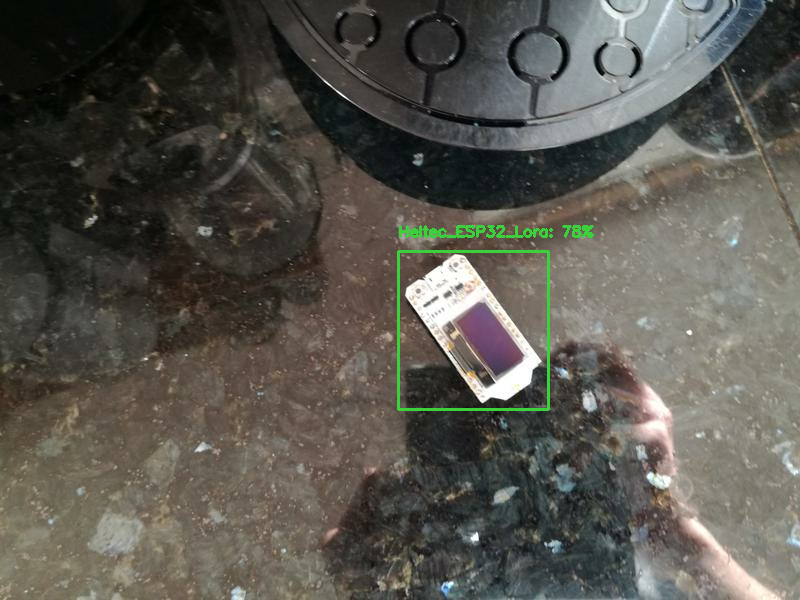

In [ ]:
INPUT_IMAGE_URL = "/content/microcontroller-detection/test/IMG_20181228_102641.jpg"
DETECTION_THRESHOLD = 0.5 

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    INPUT_IMAGE_URL, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)